In [1]:
import xarray as xr
import gcsfs
import intake
import numpy as np
import matplotlib
#import cmocean
import stats
import stats as st
from matplotlib import pyplot as plt
%matplotlib inline
import ecco_v4_tools as ecco
# Import plotting libraries
import importlib
import llcmapping
from llcmapping import LLCMapper

importlib.reload(llcmapping)
importlib.reload(ecco)

/srv/conda/envs/notebook/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


<module 'ecco_v4_tools' from '/home/jovyan/ecco_v4_tools/__init__.py'>

Set up plotting parameters.

In [2]:
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'axes.titlesize': 16})
matplotlib.rcParams.update({'figure.figsize': (10,8)})
matplotlib.rcParams.update({'lines.linewidth': 2})
matplotlib.rcParams.update({'legend.fontsize': 18})
matplotlib.rcParams.update({'mathtext.fontset': 'cm'})
matplotlib.rcParams.update({'ytick.major.size': 3})
matplotlib.rcParams.update({'axes.labelsize': 16})
matplotlib.rcParams.update({'ytick.labelsize': 16})
matplotlib.rcParams.update({'xtick.labelsize': 16})

Open the Pangeo data catalog and load the **ECCOv4r3** product as an xarray Dataset. The dataset is *lazily* evaluated, which is a good thing considering the size is around 100 GB.  

In [3]:
cat = intake.open_catalog('catalog.yaml')
list(cat)

['sea_surface_height',
 'ECCOv4r3',
 'SOSE',
 'LLC4320_grid',
 'LLC4320_SST',
 'LLC4320_SSS',
 'LLC4320_SSH',
 'LLC4320_SSU',
 'LLC4320_SSV',
 'CESM_POP_hires_control',
 'CESM_POP_hires_RCP8_5',
 'GFDL_CM2_6_control_ocean_surface',
 'GFDL_CM2_6_control_ocean_3D',
 'GFDL_CM2_6_one_percent_ocean_surface',
 'GFDL_CM2_6_one_percent_ocean_3D',
 'GFDL_CM2_6_grid']

In [4]:
ds = cat.ECCOv4r3.to_dask()
ds

<xarray.Dataset>
Dimensions:    (face: 13, i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 288, time_snp: 287)
Coordinates:
    Depth      (face, j, i) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    PHrefC     (k) float32 dask.array<shape=(50,), chunksize=(50,)>
    PHrefF     (k_p1) float32 dask.array<shape=(51,), chunksize=(51,)>
    XC         (face, j, i) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    XG         (face, j_g, i_g) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    YC         (face, j, i) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    YG         (face, j_g, i_g) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    Z          (k) float32 dask.array<shape=(50,), chunksize=(50,)>
    Zl         (k_l) float32 dask.array<shape=(50,), chunksize=(50,)>
    Zp1        (k_p1) float32 dask.array<shape=(51,), chunksize=(51,)>
    Zu         (k_u) float32 dask.array<

In [5]:
ds.nbytes / 1e12

0.134190544604

Drop the coordinates from the main dataset; a trick to make things work a bit faster.

In [6]:
coords = ds.coords.to_dataset().reset_coords()
ds = ds.reset_coords(drop=True)

Load ECCO mixed layer depth from my **Google Cloud Bucket**. Data can be easily and inexpensively be stored on the **Google cloud** here: https://cloud.google.com/

In [7]:
ds_MXLDEPTH = xr.open_zarr(gcsfs.GCSMap('ecco-data/MXLDEPTH'))
mxldepth = ds_MXLDEPTH.MXLDEPTH

For some reason the mixed layer depth coordinate indices are displaced by +1 in relation to the ECCO data stored on Pangeo. The coordinates need to be matched for future calculations. 

In [8]:
mxldepth.coords['i'] = coords['i']
mxldepth.coords['j'] = coords['j']
mxldepth

<xarray.DataArray 'MXLDEPTH' (face: 13, time: 288, j: 90, i: 90)>
dask.array<shape=(13, 288, 90, 90), dtype=float64, chunksize=(1, 288, 90, 90)>
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
    lat      (face, j, i) float64 dask.array<shape=(13, 90, 90), chunksize=(1, 90, 90)>
    lon      (face, j, i) float64 dask.array<shape=(13, 90, 90), chunksize=(1, 90, 90)>
    tim      (time) datetime64[ns] dask.array<shape=(288,), chunksize=(288,)>
  * time     (time) float64 1.0 2.0 3.0 4.0 5.0 ... 285.0 286.0 287.0 288.0
Dimensions without coordinates: face
Attributes:
    long_name:  Mixed-Layer Depth (>0)
    units:      m

Calculate climatological mean mixed layer depth. We will be using this later to mask grid points outside of the mixed layer. 

In [9]:
mxldepth_clim=mxldepth.mean(dim='time').load()

Make a mask of points outside the ocean mixed layer:

In [10]:
mxlpoints = np.abs(coords['Z']) <= mxldepth_clim

Import the plotting library. This will help with mapping fields from the LLC90 grid that ECCO utilizes (see https://www.geosci-model-dev.net/8/3071/2015/gmd-8-3071-2015.pdf) to a standard latitude-longitude grid. 

Let's test how long it takes to load sea-surface temperature (SST) into memory.

In [11]:
#%time ds.THETA.isel(k=0).mean(dim='time').load()

`xgcm` is a python package for working with the datasets produced by numerical General Circulation Models (GCMs) and similar gridded datasets that are amenable to finite volume analysis. This will come in handy later when performing calculus on the LLC90 grid.

In [12]:
import xgcm

# define the connectivity between faces
face_connections = {'face':
                    {0: {'X':  ((12, 'Y', False), (3, 'X', False)),
                         'Y':  (None,             (1, 'Y', False))},
                     1: {'X':  ((11, 'Y', False), (4, 'X', False)),
                         'Y':  ((0, 'Y', False),  (2, 'Y', False))},
                     2: {'X':  ((10, 'Y', False), (5, 'X', False)),
                         'Y':  ((1, 'Y', False),  (6, 'X', False))},
                     3: {'X':  ((0, 'X', False),  (9, 'Y', False)),
                         'Y':  (None,             (4, 'Y', False))},
                     4: {'X':  ((1, 'X', False),  (8, 'Y', False)),
                         'Y':  ((3, 'Y', False),  (5, 'Y', False))},
                     5: {'X':  ((2, 'X', False),  (7, 'Y', False)),
                         'Y':  ((4, 'Y', False),  (6, 'Y', False))},
                     6: {'X':  ((2, 'Y', False),  (7, 'X', False)),
                         'Y':  ((5, 'Y', False),  (10, 'X', False))},
                     7: {'X':  ((6, 'X', False),  (8, 'X', False)),
                         'Y':  ((5, 'X', False),  (10, 'Y', False))},
                     8: {'X':  ((7, 'X', False),  (9, 'X', False)),
                         'Y':  ((4, 'X', False),  (11, 'Y', False))},
                     9: {'X':  ((8, 'X', False),  None),
                         'Y':  ((3, 'X', False),  (12, 'Y', False))},
                     10: {'X': ((6, 'Y', False),  (11, 'X', False)),
                          'Y': ((7, 'Y', False),  (2, 'X', False))},
                     11: {'X': ((10, 'X', False), (12, 'X', False)),
                          'Y': ((8, 'Y', False),  (1, 'X', False))},
                     12: {'X': ((11, 'X', False), None),
                          'Y': ((9, 'Y', False),  (0, 'X', False))}}}

# create the grid object
grid = xgcm.Grid(ds, periodic=False, face_connections=face_connections)

## Deriving the Temperature Variance Equation

Conservation of heat requires the following equation:


$\large
\begin{align}
\frac{\partial (s^{*} \theta)}{\partial t} = -\nabla_{z^{*}} \cdot (s^{*} \mathbf{u} \theta) - \frac{\partial (s^{*}w \theta)}{\partial z^{*}} +   s^{*}\mathit{D}_\theta + \frac{s^{*}}{\rho c_p} \frac {\partial \mathit{F}_\theta}{\partial z} 
\end{align}$


Here, $s^{*} = 1 + \eta / H$ is a scale factor, which arises because the equations are expressed in terms of a re-scaled height coordinate:

$\large z^{*} = \frac{ z - \eta (x,y,t)}{H(x,y) + \eta (x,y,t)} H(x,y)$

where $\eta$ is the surface height and $H$ is the ocean depth.

In the conservation of heat equation, $\theta$ is the potential temperature, $\mathbf{u}$ and $w$ are total horizontal and vertical velocities, respectively, $\mathit{D_\theta}$ is the heat flux convergence due to diffusive procesess, and $\mathit{F_\theta}$ is the surface forcing (sum of surface latent, sensible and radiative heat fluxes) and geothermal forcing term. 

At a given depth $z^{*}=z_k$ with vertical thickness $\Delta z^{*} = \Delta {z_k}$, the conservation equation becomes: 


$\large
\begin{align}
\rho c_p \Delta z_k \frac{\partial (s^{*} \theta)}{\partial t} = -\rho c_p \Delta z_k \left(\nabla_{z^{*}} \cdot (s^{*} \mathbf{u} \theta) - \frac{\Delta (s^{*}w \theta)}{\Delta z_k} +   s^{*}\mathit{D}_\theta \right) + s^{*} \Delta \mathit{F}_\theta
\end{align}$

where $\Delta = x_{k+1} - x_k$, is the vertical difference in a variable $x$ at depth $z_k$. This is essentially the vertically discretized version of the conservation equation.

For simplicity, we now define the following terms:

$\large
\begin{align}
    T &= s^{*} \theta \\
    C_{T,adv} &= -\rho c_p \Delta z_k \left( \nabla_{z^{*}} \cdot (s^{*} \mathbf{u} \theta) - \frac{\Delta (s^{*}w \theta)}{\Delta z_k} \right) \\
    C_{T,diff} &= \rho c_p \Delta z_k s^{*}\mathit{D}_\theta \\
    C_{T,forc} &= s^{*} \Delta \mathit{F}_\theta
\end{align}$

where $T$ is the scaled potential temperature (essentially equal to the actual temperature), $C_{T,adv}$ is the advective heat flux convergence, $C_{T,diff}$ is the diffusive heat flux convergence and $C_{T,forc}$ is the surface forcing. This yields the following equation:

$\large
\begin{align}
c_o(z) \frac{\partial T}{\partial t} = C_{T,adv} + C_{T,diff} + C_{T,forc} 
\end{align}$

where I have defined $c_o(z) = \rho c_p \Delta z_k$ as the ocean heat capacity at depth $z_k$. To form the temperature variance equation, we must now subtract the climatological mean (anomalies now denoted with the prime notation) and discretize in time. This yields the following equation:

$\large
\begin{align}
c_o(z) \frac{T'(t+\Delta t) - T'(t)}{\Delta t} = C'_{T,adv} + C'_{T,diff} + C'_{T,forc}
\end{align}$

Squaring both sides and taking the time average of the previous equation (denoted by overbar) yields the following equation:

$\large
\begin{align}
2\frac{c^2_o(z)}{\Delta t^2} \left(\overline{T'^2(t)} - \overline{T'(t+\Delta t)T'(t)}\right) = \overline{\left(C'_{T,adv} + C'_{T,diff} + C'_{T,forc}\right)^2}
\end{align}$

Rewritting $\overline{T'(t+\Delta t)T'(t)}$ as $r_1 \overline{T'^2(t)}$, where $r_1$ is the lag-1 temperature autocorrelation, and defining $\sigma^2_T = \overline{T'^2(t)}$ as the temperature variance yields the following equation: 

$\large
\begin{align}
\sigma^2_T (z) = \frac{\Delta t^2}{2 c^2_o(z) (1-r_1)} = \overline{\left(C'_{T,adv} + C'_{T,diff} + C'_{T,forc}\right)^2}
\end{align}$


Finally, we re-write the RHS of the previous equation slightly by substituting a single instance of the conservation equation. This yields:

$\large
\begin{align}
\sigma^2_T (z) = \frac{\Delta t^2}{2c_o(z) (1-r_1)} \left(\overline{\frac{\partial T'}{\partial t} C'_{T,adv}} + \overline{\frac{\partial T'}{\partial t} C'_{T,diff}} + \overline{\frac{\partial T'}{\partial t} C'_{T,forc}}\right)
\end{align}$

The temperature variance at depth $z$ is therefore determined by the covariance between the time tendency of the temperature and the different terms in the ocean energy budget, scaled by the factor $\frac{\Delta t^2}{2c_o(z) (1-r_1)}$. 

We will integrate this equation across the climatological ocean mixed layer to better understand the processes that contribute to sea-surface temperature (SST) variance. 

In [13]:
# Face numbers to analyze
facen = [2,10]
# Plotting bounds
bnds = [280,360,12,70]

lons = coords.XC.isel(face=facen)
lats = coords.YC.isel(face=facen)

`mapper` is the object we will use to plot fields later.

In [14]:
mapper = LLCMapper(coords.isel(face=facen))

Load the required monthly fields.

In [15]:
# Load monthly temperature snapshot
THETAsnp = ds.THETA_snp.isel(face=facen)
THETAsnp = THETAsnp.rename({'time_snp':'time'})
THETAsnp_anom = THETAsnp


# Load monthly surface height snapsnot
ETANsnp = ds.ETAN_snp.isel(face=facen)
ETANsnp = ETANsnp.rename({'time_snp':'time'})
ETANsnp_anom = ETANsnp


# Ocean depth (m)
Depth = coords.Depth.isel(face=facen).load()

# Calculate s
sstar = (1+ETANsnp/Depth)

# Calculate s^*theta (essentially equal to monthly anomalies of theta)
HCsnp_anom = THETAsnp*sstar

# Surface heat flux
Qs_anom = ds.TFLUX.isel(face=facen)
oceQsw_anom = ds.oceQsw.isel(face=facen)

# Advection
ADVx_TH_anom = ds.ADVx_TH.isel(face=facen)
ADVy_TH_anom = ds.ADVy_TH.isel(face=facen)
ADVr_TH_anom = ds.ADVr_TH.isel(face=facen)

# Diffusion 
DFxE_TH_anom = ds.DFxE_TH.isel(face=facen)
DFyE_TH_anom = ds.DFyE_TH.isel(face=facen)
DFrE_TH_anom = ds.DFrE_TH.isel(face=facen)
DFrI_TH_anom = ds.DFrI_TH.isel(face=facen)


# Calculate monthly anomalies
#THETAsnp_anom, THETAsnp_clim = st.anom(THETAsnp)
#ETANsnp_anom, ETANsnp_clim = st.anom(ETANsnp)

#sstar_anom, sstar_clim = st.anom(sstar)
#HCsnp_anom, HCsnp_clim = st.anom(THETAsnp*sstar) 
#Qs_anom, Qs_clim = st.anom(Qs_anom)
#oceQsw_anom, oceQsw_clim = st.anom(oceQsw_anom)

#ADVx_TH_anom, ADVx_TH_clim = st.anom(ADVx_TH_anom)
#ADVy_TH_anom, ADVy_TH_clim  = st.anom(ADVy_TH_anom)
#ADVr_TH_anom, ADVr_TH_clim  = st.anom(ADVr_TH_anom)

#DFxE_TH_anom, DFxE_TH_clim = st.anom(DFxE_TH_anom)
#DFyE_TH_anom, DFyE_TH_clim = st.anom(DFyE_TH_anom)
#DFrE_TH_anom, DFrE_TH_clim = st.anom(DFrE_TH_anom)
#DFrI_TH_anom, DFrI_TH_clim = st.anom(DFrI_TH_anom)

Note that $s^{*}$ is very small, such that $s^{*}\theta \approx \theta$.

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7f07fdbe69e8>)

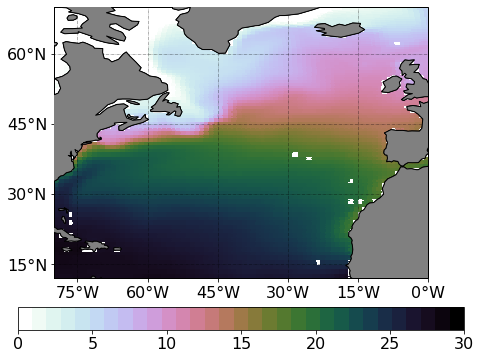

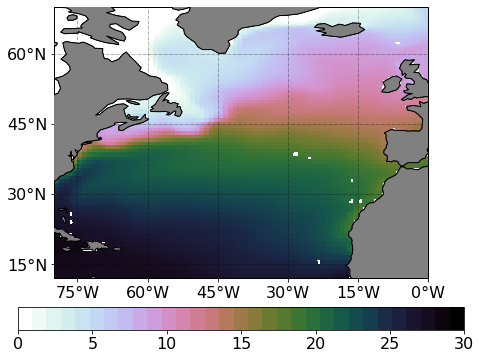

In [16]:
plt.figure(figsize=(8,6))
ecco.plot_proj_to_latlon_grid(lons, lats, THETAsnp_anom.isel(time=10,k=0), 
                              plot_type = 'pcolormesh', levels=31, cmin=0, cmax=30,
                              bnds=bnds, cmap = plt.cm.cubehelix_r, projection_type='PlateCaree',
                              show_colorbar=True, less_output=True)
#THETAsnp_anom[10,1,:].plot.pcolormesh(cmap='RdBu_r')
plt.figure(figsize=(8,6))
#HCsnp_anom[10,1,:].plot.pcolormesh(cmap='RdBu_r')
ecco.plot_proj_to_latlon_grid(lons, lats, HCsnp_anom.isel(time=10,k=0), 
                              plot_type = 'pcolormesh', levels=31, cmin=0, cmax=30,
                              bnds=bnds, cmap = plt.cm.cubehelix_r, projection_type='PlateCaree',
                              show_colorbar=True, less_output=True)


Before doing the budget calculations, a few parameters need to be defined:

In [17]:
dt = coords.time_snp[1:].load()
dt = dt.rename({'time_snp': 'time'})
# delta t in seconds. Note: divide by 10**9 to convert nanoseconds to seconds
dt.values = [float(t)/10**9 for t in np.diff(coords.time_snp)]

# time axis of dt should be the same as of the monthly averages
dt.time.values = coords.time[1:-1].values

In [18]:
rho0 = 1029 #sea-water density (kg/m^3)
c_p = 3994 #sea-water heat capacity (J/kg/K)

# Constants for surface heat penetration (from Table 2 of Paulson and Simpson, 1977)
R = 0.62
zeta1 = 0.6
zeta2 = 20.0

In [19]:
dxG = coords.dxG.isel(face=facen).load()
dyG = coords.dyG.isel(face=facen).load()

In [20]:
# Vertical grid spacing
drF = coords.drF.load()
hFacC = coords.hFacC.isel(face=facen).load()
rA = coords.rA.isel(face=facen).load()
vol = drF*hFacC*rA.load()

In [21]:
# Make copy of hFacC
mskC = hFacC.copy(deep=True).load()

# Change all fractions (ocean) to 1. land = 0
mskC.values[mskC.values>0] = 1

In [22]:
# Make 2D land mask for surface (This is just for plotting/mapping purposes)
land_mask = mskC[0]
land_mask.values[land_mask.values==0] = np.nan

## Evaluating the heat budget

### Total Tendency

In [23]:
# Total tendency (degC/month)
tendH_perMonth = (HCsnp_anom.shift(time=-1)-HCsnp_anom)[:-1]
#tendH_perMonth = HCsnp_anom[:]-HCsnp_anom[:-1]

In [24]:
tendH_perMonth

<xarray.DataArray (time: 286, k: 50, face: 2, j: 90, i: 90)>
dask.array<shape=(286, 50, 2, 90, 90), dtype=float32, chunksize=(1, 50, 2, 90, 90)>
Coordinates:
  * face     (face) int64 2 10
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-11-01

In [25]:
# Make sure time axis is the same as for the monthly variables
tendH_perMonth.time.values = ds.time[1:-1].values

In [26]:
# Convert tendency from 1/month to 1/s
tendH_perSec = tendH_perMonth/dt
tendH_perSec = tendH_perSec.transpose('face','time', 'k', 'j', 'i')

In [27]:
tendH_perSec.load()

<xarray.DataArray (face: 2, time: 286, k: 50, j: 90, i: 90)>
array([[[[[-5.891040e-08, ...,  1.806340e-07],
          ...,
          [          nan, ...,           nan]],

         ...,

         [[ 0.000000e+00, ...,  0.000000e+00],
          ...,
          [          nan, ...,           nan]]],


        ...,


        [[[-4.720673e-07, ..., -2.510099e-07],
          ...,
          [          nan, ...,           nan]],

         ...,

         [[ 0.000000e+00, ...,  0.000000e+00],
          ...,
          [          nan, ...,           nan]]]],



       [[[[          nan, ...,  2.269186e-07],
          ...,
          [          nan, ..., -6.803988e-08]],

         ...,

         [[          nan, ...,  0.000000e+00],
          ...,
          [          nan, ...,  0.000000e+00]]],


        ...,


        [[[          nan, ..., -7.396201e-08],
          ...,
          [          nan, ..., -4.893593e-07]],

         ...,

         [[          nan, ...,  0.000000e+00],
          ...,
  

In [28]:
# Define tendH array with correct dimensions
tendH = xr.DataArray(np.nan*np.zeros([len(facen),np.shape(tendH_perSec)[1]+2,50,90,90]),
                     coords={'face': facen, 'time': range(np.shape(tendH_perSec)[1]+2),'k': np.array(range(0,50)),
                             'j': np.array(range(0,90)),'i': np.array(range(0,90))},dims=['face', 'time','k', 'j','i'])


In [29]:
tendH

<xarray.DataArray (face: 2, time: 288, k: 50, j: 90, i: 90)>
array([[[[[nan, ..., nan],
          ...,
          [nan, ..., nan]],

         ...,

         [[nan, ..., nan],
          ...,
          [nan, ..., nan]]],


        ...,


        [[[nan, ..., nan],
          ...,
          [nan, ..., nan]],

         ...,

         [[nan, ..., nan],
          ...,
          [nan, ..., nan]]]],



       [[[[nan, ..., nan],
          ...,
          [nan, ..., nan]],

         ...,

         [[nan, ..., nan],
          ...,
          [nan, ..., nan]]],


        ...,


        [[[nan, ..., nan],
          ...,
          [nan, ..., nan]],

         ...,

         [[nan, ..., nan],
          ...,
          [nan, ..., nan]]]]])
Coordinates:
  * face     (face) int64 2 10
  * time     (time) int64 0 1 2 3 4 5 6 7 8 ... 280 281 282 283 284 285 286 287
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85

In [30]:
tendH.time.values = ds.time.values

# Add coordinates
tendH['XC'] = lons
tendH['YC'] = lats
tendH['Z'] = coords.Z

In [31]:
# Total tendency (degC/s)
tendH.values[:,1:-1,:] = tendH_perSec.values
tendH.load()

<xarray.DataArray (face: 2, time: 288, k: 50, j: 90, i: 90)>
array([[[[[nan, ..., nan],
          ...,
          [nan, ..., nan]],

         ...,

         [[nan, ..., nan],
          ...,
          [nan, ..., nan]]],


        ...,


        [[[nan, ..., nan],
          ...,
          [nan, ..., nan]],

         ...,

         [[nan, ..., nan],
          ...,
          [nan, ..., nan]]]],



       [[[[nan, ..., nan],
          ...,
          [nan, ..., nan]],

         ...,

         [[nan, ..., nan],
          ...,
          [nan, ..., nan]]],


        ...,


        [[[nan, ..., nan],
          ...,
          [nan, ..., nan]],

         ...,

         [[nan, ..., nan],
          ...,
          [nan, ..., nan]]]]])
Coordinates:
  * face     (face) int64 2 10
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 8

In [32]:
# Convert from degC/s to W/m^2
tendH = (rho0*c_p*drF*hFacC)*tendH

### Forcing 

In [33]:
Z = coords.sel(face=facen).Z.load()
RF = np.concatenate([coords.sel(face=facen).Zp1.values[:-1],[np.nan]])

In [34]:
q1 = R*np.exp(1.0/zeta1*RF[:-1]) + (1.0-R)*np.exp(1.0/zeta2*RF[:-1])
q2 = R*np.exp(1.0/zeta1*RF[1:]) + (1.0-R)*np.exp(1.0/zeta2*RF[1:])

In [35]:
# Correction for the 200m cutoff
zCut = np.where(Z < -200)[0][0]
q1[zCut:] = 0
q2[zCut-1:] = 0

In [36]:
# Save q1 and q2 as xarray data arrays
q1 = xr.DataArray(q1,coords=[Z.k],dims=['k'])
q2 = xr.DataArray(q2,coords=[Z.k],dims=['k'])

#### Compute vertically penetrating shortwave flux

In [37]:
# Surface heat flux (below the surface)
forcH = ((q1*(mskC==1)-q2*(mskC.shift(k=-1)==1))*oceQsw_anom).transpose('face', 'time','k','j','i')

# Reset surface layer to zero
forcH.values[:,:,0] = 0*forcH.values[:,:,0]

In [38]:
forcH.load()

<xarray.DataArray (face: 2, time: 288, k: 50, j: 90, i: 90)>
array([[[[[154.299858, ..., 152.112656],
          ...,
          [  0.      , ...,   0.      ]],

         ...,

         [[  0.      , ...,   0.      ],
          ...,
          [  0.      , ...,   0.      ]]],


        ...,


        [[[135.067701, ..., 145.257584],
          ...,
          [  0.      , ...,   0.      ]],

         ...,

         [[  0.      , ...,   0.      ],
          ...,
          [  0.      , ...,   0.      ]]]],



       [[[[  0.      , ..., 128.829749],
          ...,
          [  0.      , ..., 154.874848]],

         ...,

         [[  0.      , ...,   0.      ],
          ...,
          [  0.      , ...,   0.      ]]],


        ...,


        [[[  0.      , ...,  98.332994],
          ...,
          [  0.      , ..., 136.978616]],

         ...,

         [[  0.      , ...,   0.      ],
          ...,
          [  0.      , ...,   0.      ]]]]])
Coordinates:
  * k        (k) int64 0 1 2 3 4 5

In [39]:
# Surface heat flux (at the sea surface)
forcH[:,:,0] = ((Qs_anom - (1-(q1[0]-q2[0]))*oceQsw_anom)*mskC[0]).transpose('face', 'time','j','i')


#### Load geothermal flux (may add later)

In [40]:
# Create 3d bathymetry mask
mskC_shifted = mskC.shift(k=-1)
mskC_shifted.values[-1,:,:] = 0
mskb = mskC - mskC_shifted

In [41]:
geoflx2d = ds.GEOFLX.isel(face=facen) 
geoflx3d = geoflx2d * mskb
GEOFLX = geoflx3d.transpose('face','k','j','i') #Geothermal heat flux. Can add this to forcing later.

### Advection

#### Horizontal Convergence

In [42]:
face_connections_subset = {'face':None}

In [43]:
face_connections_subset['face'] = dict((k, face_connections['face'][k]) for k in facen if k in face_connections['face'])
face_connections_subset

{'face': {2: {'X': ((10, 'Y', False), (5, 'X', False)),
   'Y': ((1, 'Y', False), (6, 'X', False))},
  10: {'X': ((6, 'Y', False), (11, 'X', False)),
   'Y': ((7, 'Y', False), (2, 'X', False))}}}

In [44]:
# For now, construct grid based on only one face. Will change later. 
grid = xgcm.Grid(ds.isel(face=facen), periodic=False)

In [45]:
# Convergence of horizontal advection (degC/s)
adv_hConvH = -(grid.diff(ADVx_TH_anom, 'X', boundary='fill') + 
               grid.diff(ADVy_TH_anom, 'Y', boundary='fill'))/vol

#DF_TH_diff_anom = grid.diff_2d_vector({'X': DFxE_TH_anom, 'Y': DFyE_TH_anom}, boundary='fill')
#DF_TH_conv_anom_vint = -((delz/v)*DF_TH_diff_anom['X']).sum(dim='k')-((delz/v)*DF_TH_diff_anom['Y']).sum(dim='k')

In [46]:
# Convert from degC/s to W/m^2
adv_hConvH = (rho0*c_p*drF*hFacC)*adv_hConvH

#### Vertical Convergence

In [47]:
# Convergence of the vertical advection (degC m^3/s)
adv_vConvH = grid.diff(ADVr_TH_anom, 'Z', boundary='fill')/vol

# Fix for bottom layer
#adv_vConvH_temp.load()
#adv_vConvH_temp[:,-1,:,:] = -ADVr_TH_anom[:,-1,:,:]

In [48]:
# Convert from degC/s to W/m^2
adv_vConvH = (rho0*c_p*drF*hFacC)*adv_vConvH

### Diffusion

#### Horizontal Convergence

In [49]:
# Convergence of horizontal diffusion (degC/s)
dif_hConvH = -(grid.diff(DFxE_TH_anom, 'X', boundary='extend') + 
               grid.diff(DFyE_TH_anom, 'Y', boundary='extend'))/vol

In [50]:
# Convert from degC/s to W/m^2
dif_hConvH = (rho0*c_p*drF*hFacC)*dif_hConvH

#### Vertical Convergence (explicit and implicit)

In [51]:
# Convergence of vertical diffusion (degC/s)
dif_vConvH = (grid.diff(DFrE_TH_anom, 'Z', boundary='extend') 
                   + grid.diff(DFrI_TH_anom, 'Z', boundary='extend'))/vol

#Fix for bottom layer
#dif_vConvH_temp.load()
#dif_vConvH_temp[:,-1,:,:] = -(DFrE_TH_anom + DFrI_TH_anom)[:,-1,:,:]

In [52]:
# Convert from degC/s to W/m^2
dif_vConvH = (rho0*c_p*drF*hFacC)*dif_vConvH

### Total Convergence

In [53]:
# Total convergence of advective flux
adv_ConvH = adv_hConvH + adv_vConvH
#adv_ConvH = adv_ConvH.transpose('time', 'k', 'j', 'i')
adv_ConvH.load()

# Total convergence of diffusive flux
dif_ConvH = dif_hConvH + dif_vConvH
#dif_ConvH = adv_ConvH.transpose('time', 'k', 'j', 'i')
dif_ConvH.load()

# Total convergence
ConvH = adv_ConvH + dif_ConvH
ConvH.load()

<xarray.DataArray (k: 50, face: 2, j: 90, i: 90, time: 288)>
array([[[[[  133.021551, ...,   117.315659],
          ...,
          [ -325.114951, ..., -1240.047049]],

         ...,

         [[         nan, ...,          nan],
          ...,
          [         nan, ...,          nan]]],


        [[[         nan, ...,          nan],
          ...,
          [-1195.406854, ..., -2897.621805]],

         ...,

         [[         nan, ...,          nan],
          ...,
          [ -701.801238, ..., -1340.448009]]]],



       ...,



       [[[[         nan, ...,          nan],
          ...,
          [         nan, ...,          nan]],

         ...,

         [[         nan, ...,          nan],
          ...,
          [         nan, ...,          nan]]],


        [[[         nan, ...,          nan],
          ...,
          [         nan, ...,          nan]],

         ...,

         [[         nan, ...,          nan],
          ...,
          [         nan, ...,          nan]]]]]

### Sum of Convergence and Forcing

In [54]:
#GEOFLX_anom = 0
#totalH = ConvH + forcH + GEOFLX_anom
totalH = ConvH + forcH + GEOFLX
#totalH = totalH.transpose('time', 'k', 'j', 'i')
totalH.load()

<xarray.DataArray (k: 50, face: 2, j: 90, i: 90, time: 288)>
array([[[[[  -10.066126, ...,   -14.362497],
          ...,
          [ -398.103175, ..., -1401.570059]],

         ...,

         [[         nan, ...,          nan],
          ...,
          [         nan, ...,          nan]]],


        [[[         nan, ...,          nan],
          ...,
          [-1282.864584, ..., -2975.895275]],

         ...,

         [[         nan, ...,          nan],
          ...,
          [ -846.452138, ..., -1472.430933]]]],



       ...,



       [[[[         nan, ...,          nan],
          ...,
          [         nan, ...,          nan]],

         ...,

         [[         nan, ...,          nan],
          ...,
          [         nan, ...,          nan]]],


        [[[         nan, ...,          nan],
          ...,
          [         nan, ...,          nan]],

         ...,

         [[         nan, ...,          nan],
          ...,
          [         nan, ...,          nan]]]]]

In [55]:
#Error in W/m^2
error = totalH-tendH

In [56]:
# Plot sums of the error 
#mxlpoints = mxlpoints.isel(face=1)
error_sum = error.sum(dim='k').sum(dim='time')
error_sum.load()

<xarray.DataArray (face: 2, j: 90, i: 90)>
array([[[-1.451531e-03,  5.115221e-04, ...,  0.000000e+00,  1.539394e+06],
        [-3.126291e-03, -1.229209e-04, ...,  0.000000e+00,  7.285290e+05],
        ...,
        [ 0.000000e+00,  0.000000e+00, ...,  0.000000e+00,  0.000000e+00],
        [ 0.000000e+00,  0.000000e+00, ...,  0.000000e+00,  0.000000e+00]],

       [[ 0.000000e+00,  0.000000e+00, ..., -1.388760e-03, -7.781502e+05],
        [ 0.000000e+00,  0.000000e+00, ...,  2.571501e-03, -8.038772e+05],
        ...,
        [ 0.000000e+00,  0.000000e+00, ..., -1.002707e-03, -3.310284e+05],
        [ 0.000000e+00,  0.000000e+00, ..., -8.045310e+05, -5.784618e+05]]])
Coordinates:
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * face     (face) int64 2 10
    XC       (face, j, i) float32 -37.5 -36.5 -35.5 -34.5 ... -38.5 -38.5 -38.5
    YC       (face, j, i) float32 10.458642

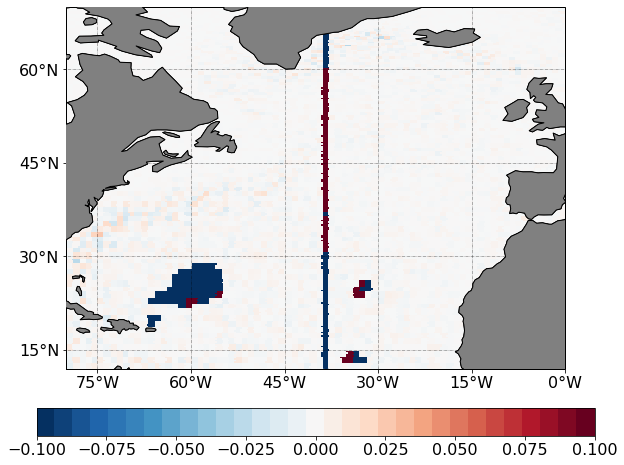

In [57]:
#(error_sum*land_mask)[1:89,1:89].plot.pcolormesh(vmin=-0.2, vmax=0.2, cmap='RdBu_r')
fig = ecco.plot_proj_to_latlon_grid(lons, lats, error_sum, 
                              plot_type = 'pcolormesh', levels=31, cmin=-0.1, cmax=0.1,
                              bnds=bnds, cmap = plt.cm.RdBu_r, projection_type='PlateCaree',
                              show_colorbar=True, less_output=True)

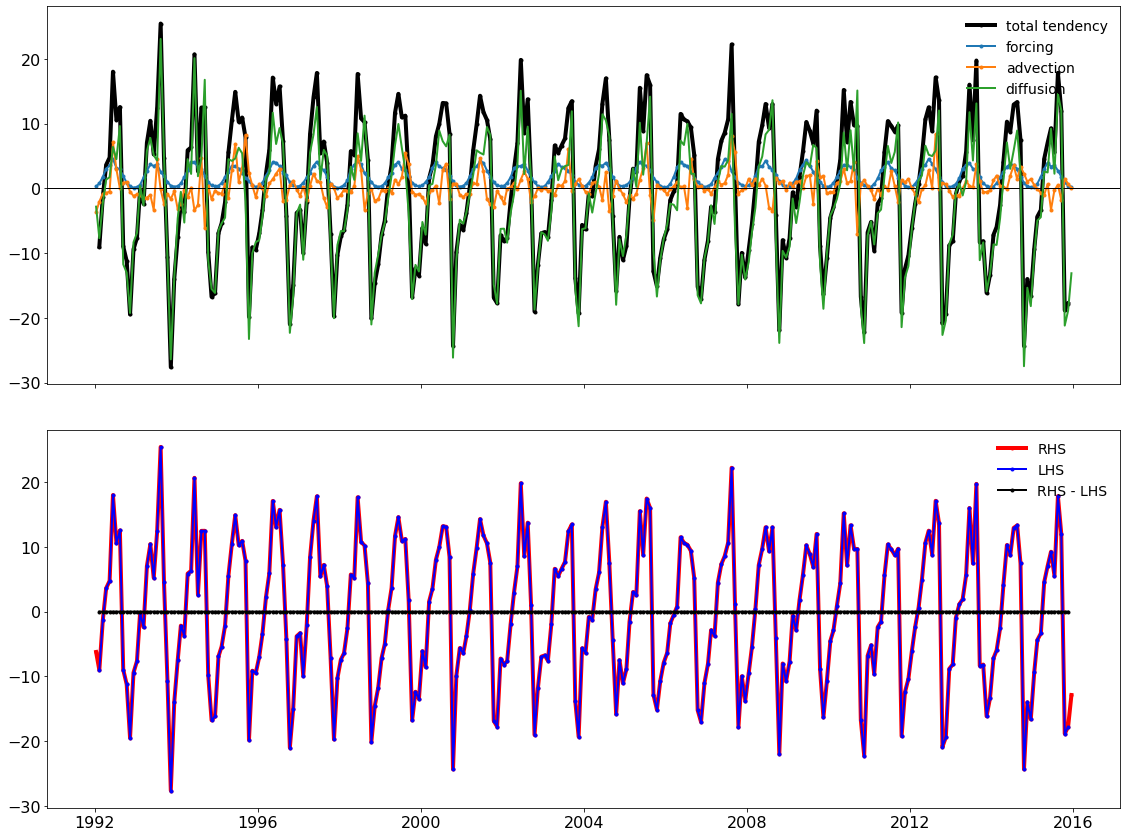

In [58]:
# Plot time series of the different terms for arbitrarily chosen grid point
face=0
k = 4
j = 60
i = 10

f, axes = plt.subplots(2, 1,figsize=(16,12))
f.tight_layout()

adv_ConvH = adv_ConvH.transpose('face', 'time', 'k', 'j', 'i')
dif_ConvH = dif_ConvH.transpose('face', 'time', 'k', 'j', 'i')
totalH = totalH.transpose('face', 'time', 'k', 'j', 'i')
tendH = tendH.transpose('face', 'time', 'k', 'j', 'i')

plt.subplot(2, 1, 1)
plt.plot(tendH.time, tendH[face,:,k,j,i], lw=4, color='K', marker='.',label='total tendency')
plt.plot(forcH.time, forcH[face,:,k,j,i], lw=2, color='C0', marker='.',label='forcing')
plt.plot(adv_ConvH.time, adv_ConvH[face,:,k,j,i], lw=2, color='C1', marker='.',label='advection')
plt.axhline(0,color='k',lw=1)
plt.plot(dif_ConvH.time, dif_ConvH[face,:,k,j,i], lw=2, color='C2',label='diffusion')
plt.setp(plt.gca(), 'xticklabels',[])
plt.legend(loc='best',frameon=False,fontsize=14)

plt.subplot(2, 1, 2)
plt.plot(totalH.time, totalH[face,:,k,j,i], lw=4, color='red', marker='.',label='RHS')
plt.plot(tendH.time, tendH[face,:,k,j,i], lw=2, color='blue', marker='.',label='LHS')
plt.plot(tendH.time, totalH[face,:,k,j,i]-tendH[face,:,k,j,i], lw=2, color='k', marker='.',label='RHS - LHS')
plt.legend(loc='best',frameon=False,fontsize=14)

## Evaluating the Temperature Variance Equation

Now that we have shown that the heat budget is balanced, we return to the temperature variance equation:

$\large
\begin{align}
\sigma^2_T (z) = \frac{\Delta t^2}{2c_o(z) (1-r_1)} \left(\overline{\frac{\partial T'}{\partial t} C'_{T,adv}} + \overline{\frac{\partial T'}{\partial t} C'_{T,diff}} + \overline{\frac{\partial T'}{\partial t} C'_{T,forc}}\right)
\end{align}$

Define some parameters:

In [59]:
T_anom, T_clim = st.anom(THETAsnp*sstar) 

In [60]:
C_adv = adv_ConvH
C_dif = dif_ConvH
C_forc = forcH

In [61]:
c_o = rho0*c_p*drF*hFacC

In [62]:
T_anom = T_anom.transpose('time', 'face', 'k', 'j', 'i')

In [63]:
T_anom.shape

(287, 2, 50, 90, 90)

In [64]:
r_1 = st.cor(T_anom, T_anom,lagx=1).load()
r_1

<xarray.DataArray (face: 2, k: 50, j: 90, i: 90)>
array([[[[0.811867, ..., 0.362378],
         ...,
         [     nan, ...,      nan]],

        ...,

        [[     nan, ...,      nan],
         ...,
         [     nan, ...,      nan]]],


       [[[     nan, ..., 0.823998],
         ...,
         [     nan, ..., 0.816552]],

        ...,

        [[     nan, ...,      nan],
         ...,
         [     nan, ...,      nan]]]], dtype=float32)
Coordinates:
  * face     (face) int64 2 10
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49

In [65]:
# Convert from W/m^2 to K/s 
tendT = tendH/(c_o)

In [66]:
adv_ConvH = adv_ConvH.transpose('time', 'face', 'k', 'j', 'i')
dif_ConvH = dif_ConvH.transpose('time', 'face', 'k', 'j', 'i')
forcH = forcH.transpose('time', 'face', 'k', 'j', 'i')
tendT = tendT.transpose('time', 'face', 'k', 'j', 'i')

In [67]:
C_adv_anom, C_adv_clim = st.anom(adv_ConvH)
C_dif_anom, C_dif_clim = st.anom(dif_ConvH)
C_forc_anom, C_forc_clim = st.anom(forcH)
tendT_anom, tendT_clim = st.anom(tendT)

In [68]:
T_var = T_anom.var(dim='time')
T_var.load()

<xarray.DataArray (face: 2, k: 50, j: 90, i: 90)>
array([[[[0.173705, ..., 0.33101 ],
         ...,
         [     nan, ...,      nan]],

        ...,

        [[0.      , ..., 0.      ],
         ...,
         [     nan, ...,      nan]]],


       [[[     nan, ..., 0.31265 ],
         ...,
         [     nan, ..., 0.17576 ]],

        ...,

        [[     nan, ..., 0.      ],
         ...,
         [     nan, ..., 0.      ]]]], dtype=float32)
Coordinates:
  * face     (face) int64 2 10
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49

In [69]:
cov_adv = st.cov(tendT_anom, C_adv_anom).load()
cov_dif = st.cov(tendT_anom, C_dif_anom).load()
cov_forc = st.cov(tendT_anom, C_forc_anom).load()

In [70]:
deltat = dt.mean()
deltat.load()

<xarray.DataArray 'time_snp' ()>
array(2629460.13986)

In [71]:
fac = (deltat**2/(2*c_o*(1-r_1)))
fac.load()

<xarray.DataArray (k: 50, face: 2, j: 90, i: 90)>
array([[[[447111.529757, ..., 131921.717772],
         ...,
         [          nan, ...,           nan]],

        [[          nan, ..., 477927.734183],
         ...,
         [          nan, ..., 458527.727461]]],


       ...,


       [[[          nan, ...,           nan],
         ...,
         [          nan, ...,           nan]],

        [[          nan, ...,           nan],
         ...,
         [          nan, ...,           nan]]]])
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * face     (face) int64 2 10

In [72]:
T_var_sum = fac*(cov_adv + cov_dif + cov_forc)

In [73]:
T_var_sum.load()

<xarray.DataArray (k: 50, face: 2, j: 90, i: 90)>
array([[[[ 0.173647, ...,  0.40011 ],
         ...,
         [      nan, ...,       nan]],

        [[      nan, ..., -2.030298],
         ...,
         [      nan, ...,  0.644799]]],


       ...,


       [[[      nan, ...,       nan],
         ...,
         [      nan, ...,       nan]],

        [[      nan, ...,       nan],
         ...,
         [      nan, ...,       nan]]]])
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * face     (face) int64 2 10
    XC       (face, j, i) float32 -37.5 -36.5 -35.5 -34.5 ... -38.5 -38.5 -38.5
    YC       (face, j, i) float32 10.458642 10.458642 ... 11.438585 10.458642
    Z        (k) float32 -5.0 -15.0 -25.0 -35.0 ... -5039.25 -5461.25 -5906.25

(<Figure size 720x576 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7f0795cc3e10>)

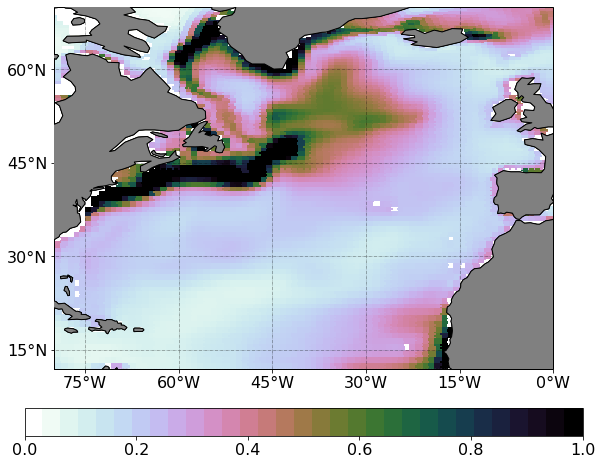

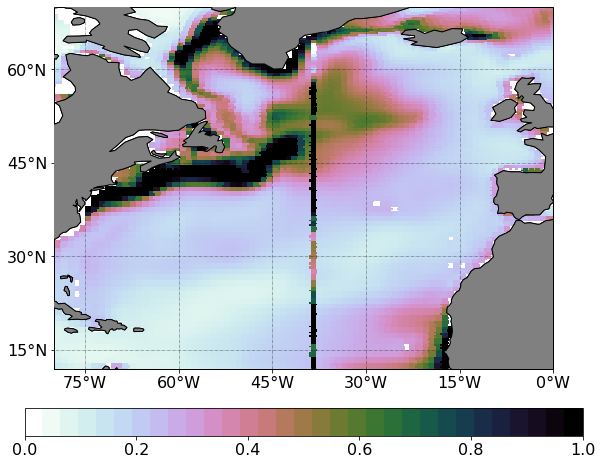

In [74]:
#f, axes = plt.subplots(2,1,figsize=(16,12))
#plt.subplot(2,1,1)
plt.figure()
ecco.plot_proj_to_latlon_grid(lons, lats, T_var.isel(k=k), 
                              bnds=bnds, plot_type = 'pcolormesh', levels=31, cmin=0, cmax=1.0,
                              cmap = plt.cm.cubehelix_r, projection_type='PlateCaree',
                              show_colorbar=True, less_output=True)
plt.figure()
ecco.plot_proj_to_latlon_grid(lons, lats,T_var_sum.isel(k=k), 
                              bnds=bnds,  plot_type = 'pcolormesh', levels=31, cmin=0, cmax=1.0,
                              cmap = plt.cm.cubehelix_r, projection_type='PlateCaree',
                              show_colorbar=True, less_output=True)

The temperature variance budget is clearly balanced! Let's take a look at the contribution due to each term.

In [75]:
T_var_adv = fac*cov_adv
T_var_dif = fac*cov_dif
T_var_forc = fac*cov_forc

### Contributions to temperature variance from advection, diffusion and surface forcing

(<Figure size 720x576 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7f07946454a8>)

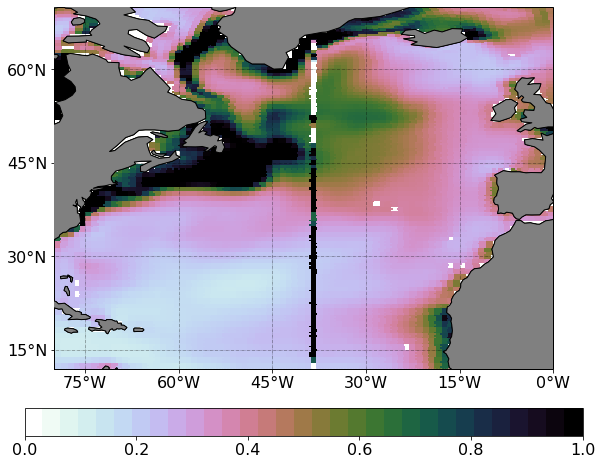

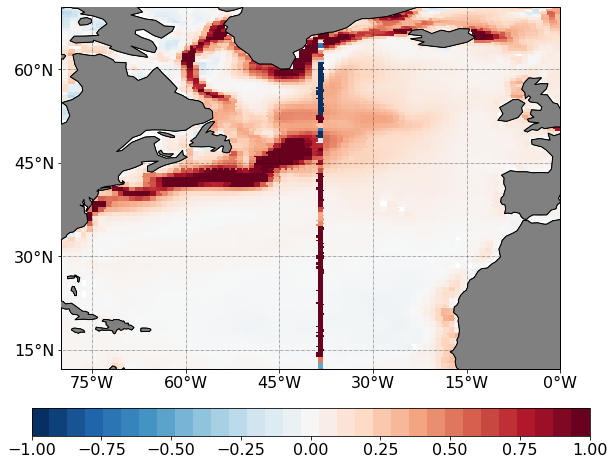

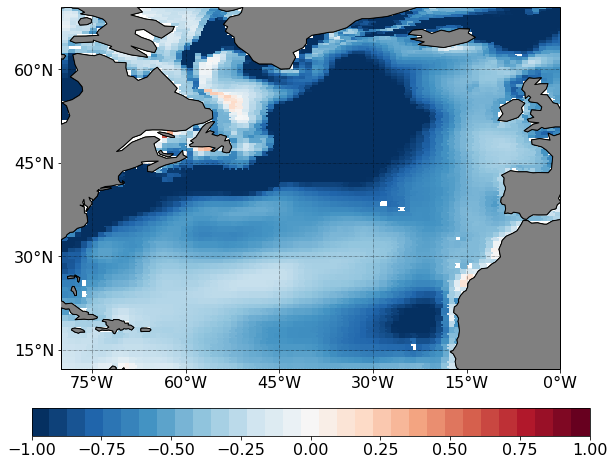

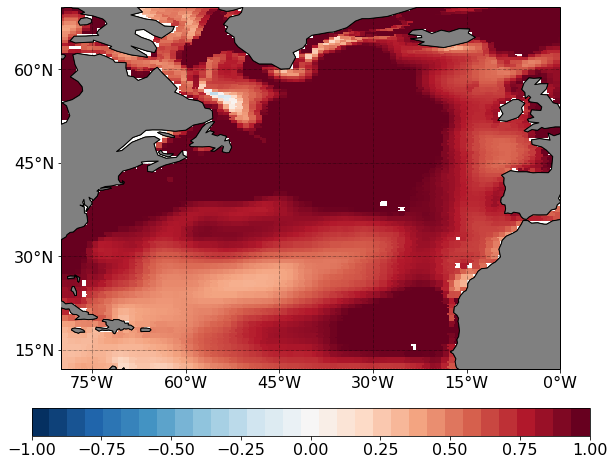

In [77]:
k=0
#f, axes = plt.subplots(2,2,figsize=(16,12))
#f.tight_layout()

plt.figure()
plt.title(r'temperature variance (K$^2$)')
ecco.plot_proj_to_latlon_grid(lons, lats, T_var_sum.isel(k=k), 
                              bnds=bnds,  plot_type = 'pcolormesh', levels=31, cmin=0, cmax=1.0,
                              cmap = plt.cm.cubehelix_r, projection_type='PlateCaree',
                              show_colorbar=True, less_output=True)
plt.figure()
plt.title(r'advective contribution (K$^2$)')
ecco.plot_proj_to_latlon_grid(lons, lats, T_var_adv.isel(k=k), 
                              bnds=bnds, plot_type = 'pcolormesh', levels=31, cmin=-1.0, cmax=1.0,
                              cmap = plt.cm.RdBu_r, projection_type='PlateCaree',
                              show_colorbar=True, less_output=True)
plt.figure()
plt.title(r'diffusive contribution (K$^2$)')
ecco.plot_proj_to_latlon_grid(lons, lats, T_var_dif.isel(k=k), 
                              bnds=bnds,  plot_type = 'pcolormesh', levels=31, cmin=-1.0, cmax=1.0,
                              cmap = plt.cm.RdBu_r, projection_type='PlateCaree',
                              show_colorbar=True, less_output=True)
plt.figure()
plt.title(r'surface forcing contribution (K$^2$)')
ecco.plot_proj_to_latlon_grid(lons, lats, T_var_forc.isel(k=k), 
                              bnds=bnds,  plot_type = 'pcolormesh', levels=31, cmin=-1.0, cmax=1.0,
                              cmap = plt.cm.RdBu_r, projection_type='PlateCaree',
                              show_colorbar=True, less_output=True)

### Contributions to ocean mixed layer temperature variance from advection, diffusion and surface forcing

In [79]:
mxlpoints = mxlpoints.isel(face=facen)
delz = drF*hFacC
delz=delz.where(mxlpoints)
delz_sum = delz.sum(dim='k')

In [80]:
weights = delz/delz_sum

In [81]:
T_var_mxl = (weights*T_var).where(mxlpoints).sum(dim='k')

In [82]:
T_var_adv_mxl = (weights*T_var_adv).where(mxlpoints).sum(dim='k')
T_var_dif_mxl = (weights*T_var_dif).where(mxlpoints).sum(dim='k')
T_var_forc_mxl = (weights*T_var_forc).where(mxlpoints).sum(dim='k')

In [83]:
T_var_sum_mxl = T_var_adv_mxl + T_var_dif_mxl + T_var_forc_mxl

(<Figure size 720x576 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7f079456d278>)

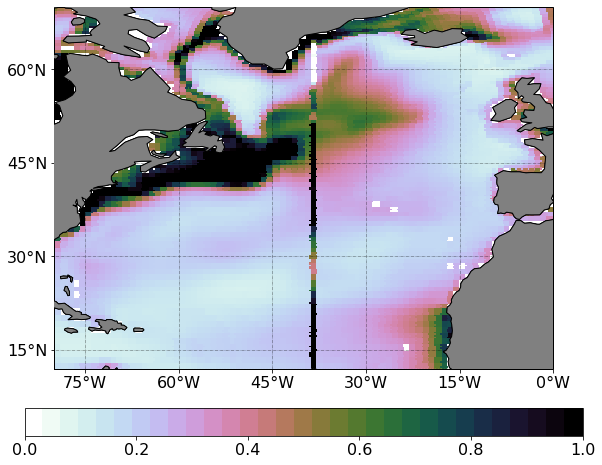

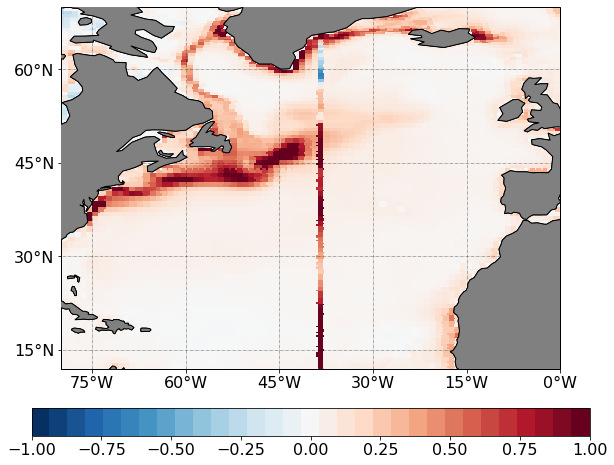

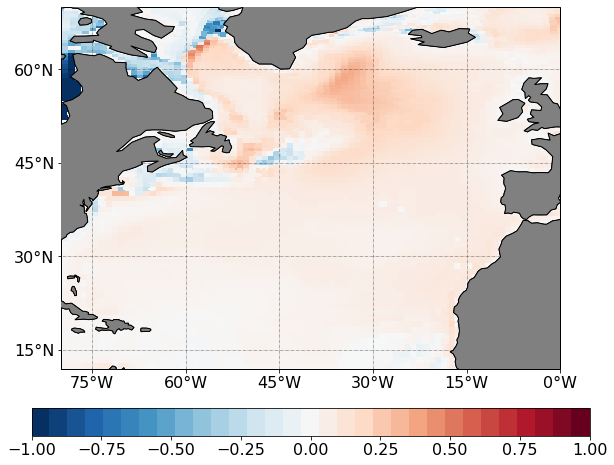

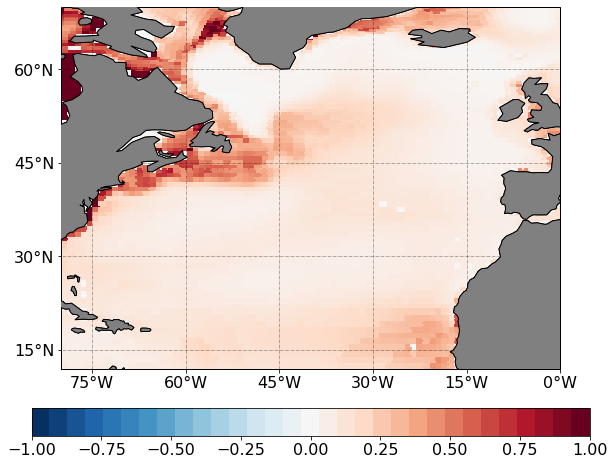

In [84]:
#f, axes = plt.subplots(2,2,figsize=(16,12))
#f.tight_layout()
plt.figure()
plt.title(r'temperature variance (K$^2$)')
ecco.plot_proj_to_latlon_grid(lons, lats, T_var_sum_mxl, 
                              bnds=bnds,  plot_type = 'pcolormesh', levels=31, cmin=0, cmax=1.0,
                              cmap = plt.cm.cubehelix_r, projection_type='PlateCaree',
                              show_colorbar=True, less_output=True)
plt.figure()
plt.title(r'advective contribution (K$^2$)')
ecco.plot_proj_to_latlon_grid(lons, lats, T_var_adv_mxl, 
                              bnds=bnds, plot_type = 'pcolormesh', levels=31, cmin=-1.0, cmax=1.0,
                              cmap = plt.cm.RdBu_r, projection_type='PlateCaree',
                              show_colorbar=True, less_output=True)
plt.figure()
plt.title(r'diffusive contribution (K$^2$)')
ecco.plot_proj_to_latlon_grid(lons, lats, T_var_dif_mxl, 
                              bnds=bnds,  plot_type = 'pcolormesh', levels=31, cmin=-1.0, cmax=1.0,
                              cmap = plt.cm.RdBu_r, projection_type='PlateCaree',
                              show_colorbar=True, less_output=True)
plt.figure()
plt.title(r'surface forcing contribution (K$^2$)')
ecco.plot_proj_to_latlon_grid(lons, lats, T_var_forc_mxl, 
                              bnds=bnds,  plot_type = 'pcolormesh', levels=31, cmin=-1.0, cmax=1.0,
                              cmap = plt.cm.RdBu_r, projection_type='PlateCaree',
                              show_colorbar=True, less_output=True)

(<Figure size 720x576 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7f0794426710>)

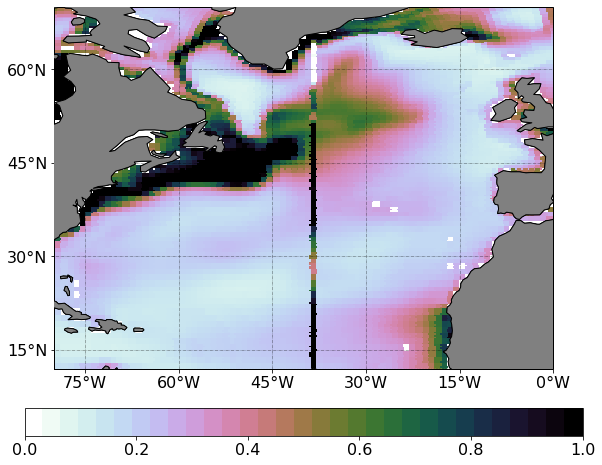

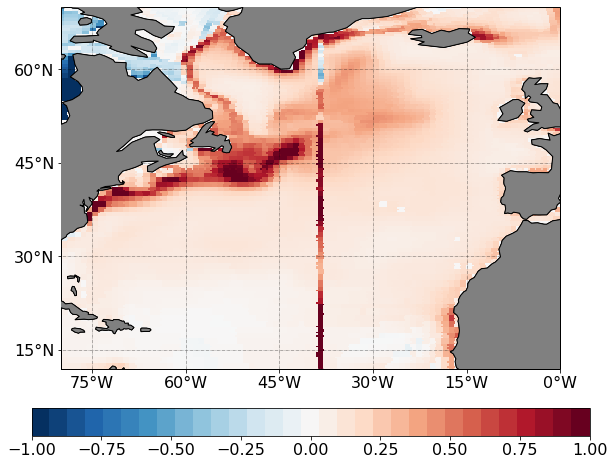

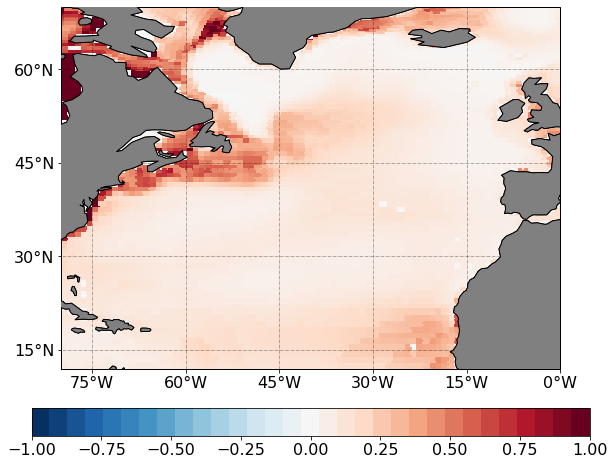

In [85]:
#f, axes = plt.subplots(2,2,figsize=(16,12))
#f.tight_layout()
plt.figure()
plt.title(r'temperature variance (K$^2$)')
ecco.plot_proj_to_latlon_grid(lons, lats, T_var_sum_mxl, 
                              bnds=bnds,  plot_type = 'pcolormesh', levels=31, cmin=0, cmax=1.0,
                              cmap = plt.cm.cubehelix_r, projection_type='PlateCaree',
                              show_colorbar=True, less_output=True)
plt.figure()
plt.title(r'ocean dynamics (advective + diffusive) contribution (K$^2$)')
ecco.plot_proj_to_latlon_grid(lons, lats, T_var_adv_mxl +  T_var_dif_mxl, 
                              bnds=bnds, plot_type = 'pcolormesh', levels=31, cmin=-1.0, cmax=1.0,
                              cmap = plt.cm.RdBu_r, projection_type='PlateCaree',
                              show_colorbar=True, less_output=True)
plt.figure()
plt.title(r'surface forcing contribution (K$^2$)')
ecco.plot_proj_to_latlon_grid(lons, lats, T_var_forc_mxl, 
                              bnds=bnds,  plot_type = 'pcolormesh', levels=31, cmin=-1.0, cmax=1.0,
                              cmap = plt.cm.RdBu_r, projection_type='PlateCaree',
                              show_colorbar=True, less_output=True)